# DQN Algorithm Implementation

This notebook is the basic implementation of DQN. It contains two parts:
- Run the model with defailt parameters
- Hyperparameters tuning

## 1. Run the model with defailt parameters
In this part, besides the given basic visulization, we add a plot to show the variance of reward as the number of episodes increase.

In [1]:
!pip install -r requirements.txt

  Using cached tqdm-4.66.5-py3-none-any.whl.metadata (57 kB)
  Using cached matplotlib-3.7.5-cp311-cp311-macosx_11_0_arm64.whl.metadata (5.7 kB)
  Using cached pandas-1.5.3-cp311-cp311-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached gymnasium-0.29.1-py3-none-any.whl.metadata (10 kB)
  Using cached numpy-1.22.0-cp311-cp311-macosx_12_0_arm64.whl
  Using cached pygame-2.5.2-cp311-cp311-macosx_11_0_arm64.whl.metadata (13 kB)
INFO: pip is looking at multiple versions of pandas to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install -r requirements.txt (line 2), -r requirements.txt (line 3) and numpy==1.22.0 because these package versions have conflicting dependencies.

The conflict is caused by:
    The user requested numpy==1.22.0
    matplotlib 3.7.5 depends on numpy<2 and >=1.20
    pandas 1.5.3 depends on numpy>=1.21.0; python_version >= "3.10"
    pandas 1.5.3 depends on numpy>=1.23.2; python_version >= "3.11"

To fix this 

Episode: 100, Total Steps: 703, Ep Step: 5, Raw Reward: 0.00, Epsilon: 0.90
Episode: 200, Total Steps: 1458, Ep Step: 4, Raw Reward: 0.00, Epsilon: 0.82
Episode: 300, Total Steps: 2394, Ep Step: 8, Raw Reward: 0.00, Epsilon: 0.74
Episode: 400, Total Steps: 3360, Ep Step: 22, Raw Reward: 0.00, Epsilon: 0.67

~~~~~~Interval Save: Model saved.

Episode: 500, Total Steps: 4420, Ep Step: 17, Raw Reward: 0.00, Epsilon: 0.61
Episode: 600, Total Steps: 5290, Ep Step: 33, Raw Reward: 0.00, Epsilon: 0.55
Episode: 700, Total Steps: 6192, Ep Step: 5, Raw Reward: 0.00, Epsilon: 0.50
Episode: 800, Total Steps: 7274, Ep Step: 7, Raw Reward: 0.00, Epsilon: 0.45
Episode: 900, Total Steps: 8448, Ep Step: 4, Raw Reward: 0.00, Epsilon: 0.41

~~~~~~Interval Save: Model saved.

Episode: 1000, Total Steps: 9529, Ep Step: 11, Raw Reward: 1.00, Epsilon: 0.37
Episode: 1100, Total Steps: 10585, Ep Step: 6, Raw Reward: 1.00, Epsilon: 0.33
Episode: 1200, Total Steps: 11906, Ep Step: 7, Raw Reward: 0.00, Epsilon: 0

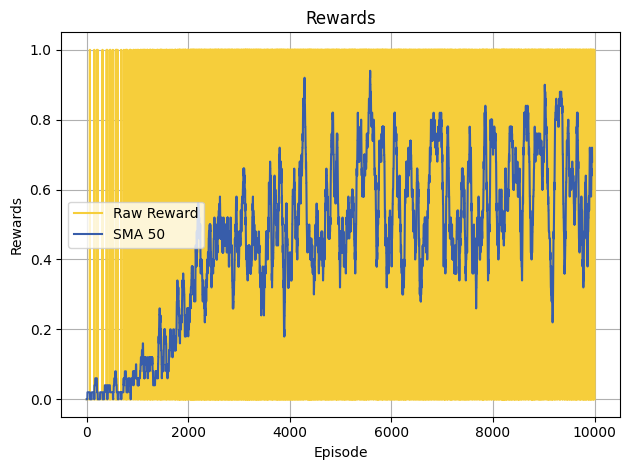

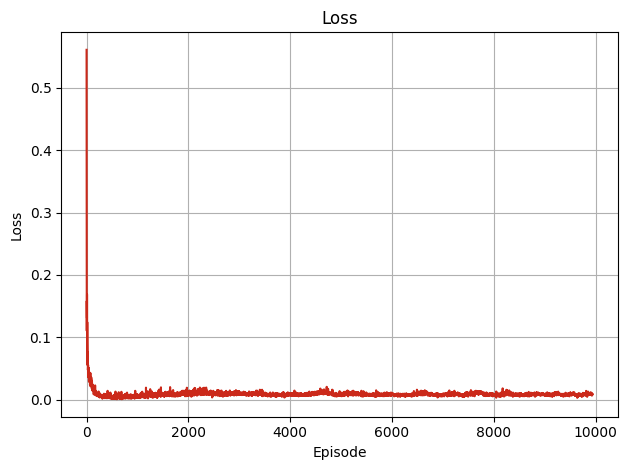

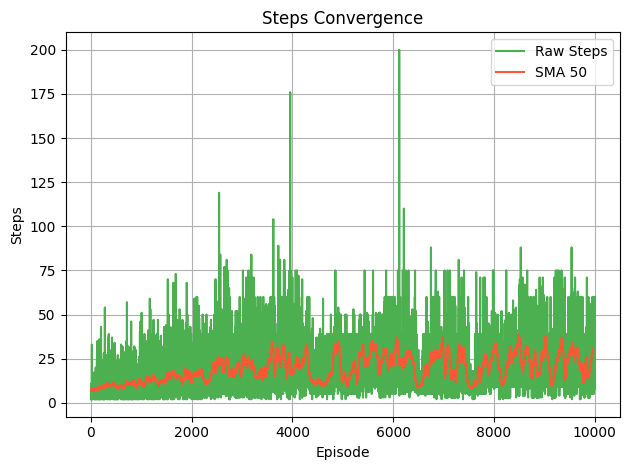

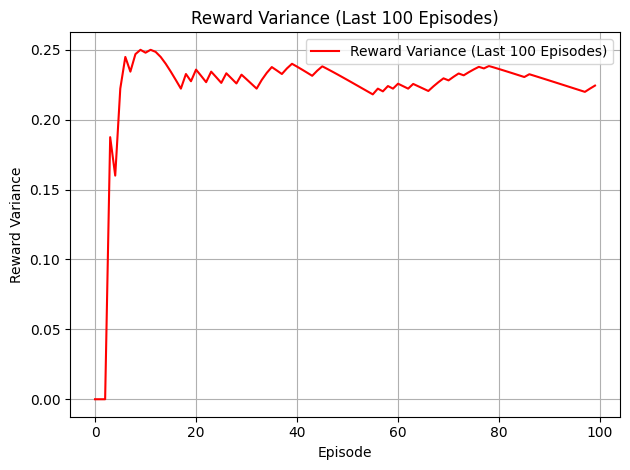

In [2]:
# Import necessary modules
import os
import gc
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
import gymnasium as gym
from agent.base_agent import BaseAgent
from utils import seed_everything

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Environment setup
gc.collect()
torch.cuda.empty_cache()
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'  # Set CUDA launch blocking to 1 for debugging CUDA-related errors


# Replay Buffer Class
class ReplayBuffer:
    def __init__(self, capacity):
        """
        Experience replay buffer used to store transitions
        """
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)

    def store(self, state, action, next_state, reward, done):
        """
        Store a transition in the buffer
        """
        self.buffer.append((state, action, next_state, reward, done))

    def sample(self, batch_size):
        """
        Randomly sample a batch of transitions from the buffer
        """
        indices = np.random.choice(len(self.buffer), size=batch_size, replace=False)
        states, actions, next_states, rewards, dones = zip(*(self.buffer[idx] for idx in indices))

        # Convert sampled transitions to tensors
        states = torch.stack(states).to(device)
        actions = torch.tensor(actions, dtype=torch.long, device=device)
        next_states = torch.stack(next_states).to(device)
        rewards = torch.tensor(rewards, dtype=torch.float32, device=device)
        dones = torch.tensor(dones, dtype=torch.bool, device=device)

        return states, actions, next_states, rewards, dones

    def __len__(self):
        return len(self.buffer)

class Qnet(nn.Module):
    def __init__(self, num_actions, input_dim):
        """
        Neural network for Deep Q-Learning
        """
        super(Qnet, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, num_actions)
        )
        self._initialize_weights()

    def forward(self, x):
        """
        Forward pass through the network
        """
        return self.fc_layers(x)


    def _initialize_weights(self):
        """
        Initialize weights for linear layers using Kaiming uniform initialization
        """
        for layer in self.fc_layers:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')


# DQN Agent Class inheriting from Agent
class DQNAgent(BaseAgent):
    def __init__(self, env, hyperparams):
        """
        DQN Agent class for interacting with the environment and learning
        """
        super(DQNAgent, self).__init__(env, hyperparams)
        self.replay_memory = ReplayBuffer(hyperparams['memory_capacity'])

        # Main and target networks
        self.model = Qnet(self.num_actions, self.state_dim).to(device)
        self.target_network = Qnet(self.num_actions, self.state_dim).to(device)
        self.update_target_network()

        # Optimizer and loss function
        self.optimizer = optim.Adam(self.model.parameters(), lr=hyperparams['learning_rate'])
        self.criterion = nn.MSELoss()
        
        # Additional hyperparameters
        self.discount = hyperparams['discount_factor']
        self.epsilon = hyperparams['epsilon_max']
        self.epsilon_min = hyperparams['epsilon_min']
        self.epsilon_decay = hyperparams['epsilon_decay']
        self.clip_grad_norm = hyperparams['clip_grad_norm']
        self.loss_history = []
        self.running_loss = 0
        self.learned_counts = 0

    def select_action(self, state):
        """
        Select an action using epsilon-greedy policy
        """
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        with torch.no_grad():
            Q_values = self.model(state)
            return torch.argmax(Q_values).item()

    def learn(self, batch_size, done):
        """
        Learn from a batch of experiences using the DQN update rule
        """
        # Sample a batch from the replay buffer
        states, actions, next_states, rewards, dones = self.replay_memory.sample(batch_size)
        actions = actions.unsqueeze(1)
        rewards = rewards.unsqueeze(1)
        dones = dones.unsqueeze(1)
        # Compute predicted Q-values and target Q-values
        predicted_q = self.model(states).gather(dim=1, index=actions)
        with torch.no_grad():
            next_target_q_value = self.target_network(next_states).max(dim=1, keepdim=True)[0]
        next_target_q_value[dones] = 0
        y_js = rewards + (self.discount * next_target_q_value)
        # Compute loss
        loss = self.criterion(predicted_q, y_js)
        self.running_loss += loss.item()
        self.learned_counts += 1
        if done:
            self.loss_history.append(self.running_loss / self.learned_counts)
            self.running_loss, self.learned_counts = 0, 0
        # Backpropagate the loss
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_grad_norm)
        self.optimizer.step()

    def update_target_network(self):
        """
        Update the target network by copying weights from the main network
        """
        self.target_network.load_state_dict(self.model.state_dict())

    def update_epsilon(self):
        """
        Update epsilon value for epsilon-greedy policy
        """
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def save(self, path):
        """
        Save the trained model
        """
        torch.save(self.model.state_dict(), path)
    
    def load(self, path):
        """
        Load the trained model
        """
        self.model.load_state_dict(torch.load(path, map_location=device))

# Trainer Class
class Trainer:
    def __init__(self, env, agent, hyperparams):
        """
        Trainer class to manage training and evaluation of the agent
        """
        self.env = env
        self.agent = agent
        self.hyperparams = hyperparams
        self.reward_history = []
        self.step_history = []
        self.variance_history = []

        if hasattr(agent, 'replay_memory'):
            self.use_replay_memory = True
        else:
            self.use_replay_memory = False

    def state_preprocess(self, state):
        """
        Convert the state to one-hot representation 
        """
        onehot_vector = torch.zeros(self.env.observation_space.n, dtype=torch.float32, device=device)
        onehot_vector[state] = 1
        return onehot_vector

    def train(self):
        """
        Train the agent for a specified number of episodes
        """
        total_steps = 0
        standard_value = 0.66  # Standard value to compare rewards

        for episode in range(1, self.hyperparams['max_episodes'] + 1):
            state, _ = self.env.reset(seed=seed)
            state = self.state_preprocess(state)
            done, truncation = False, False
            step_size, episode_reward = 0, 0

            while not done and not truncation:
                # Select and execute an action
                action = self.agent.select_action(state)
                next_state, reward, done, truncation, _ = self.env.step(action)
                next_state = self.state_preprocess(next_state)

                # use ReplayBuffer
                if self.use_replay_memory:
                    self.agent.replay_memory.store(state, action, next_state, reward, done)
                    if len(self.agent.replay_memory) > self.hyperparams['batch_size'] and sum(self.reward_history) > 0:
                        self.agent.learn(self.hyperparams['batch_size'], (done or truncation))
                        # Update target network periodically
                        if total_steps % self.hyperparams['update_frequency'] == 0:
                            self.agent.update_target_network()

                state = next_state
                episode_reward += reward
                step_size += 1

            self.reward_history.append(episode_reward)
            self.step_history.append(step_size)  # Track steps for each episode
            total_steps += step_size
            self.agent.update_epsilon()



            # Calculate the variance between current episode's reward and the standard value
            variance = (episode_reward - standard_value) ** 2
            self.variance_history.append(variance)
           
           
            # Save the model at specified intervals
            if episode % self.hyperparams['save_interval'] == 0:
                os.makedirs(self.hyperparams['model_dir'], exist_ok=True)
                self.agent.save(os.path.join(self.hyperparams['model_dir'], f'{episode}.pth'))
                print('\n~~~~~~Interval Save: Model saved.\n')
            # Print episode information at specified intervals
            if episode % self.hyperparams['print_interval'] == 0:
                print(f"Episode: {episode}, Total Steps: {total_steps}, Ep Step: {step_size}, Raw Reward: {episode_reward:.2f}, Epsilon: {self.agent.epsilon:.2f}")
        
        # Calculate the average reward of the last 100 episodes
        last_100_rewards = self.reward_history[-100:]
        avg_100 = np.mean(last_100_rewards)
        print(f"Average reward of the last 100 episodes: {avg_100:.2f}")

        self.plot_training(episode)

    def test(self, max_episodes=None):
        """
        Test the trained agent
        """
        # Load the trained model
        self.agent.load(os.path.join(self.hyperparams['model_dir'], f"{self.hyperparams['train_episodes']}.pth"))
        self.agent.model.eval()

        if max_episodes is None:
            max_episodes = self.hyperparams['max_episodes']

        for episode in range(1, max_episodes + 1):
            state, _ = self.env.reset(seed=seed)
            done, truncation = False, False
            step_size, episode_reward = 0, 0

            while not done and not truncation:
                # Select an action
                state = self.state_preprocess(state)
                action = self.agent.select_action(state)
                next_state, reward, done, truncation, _ = self.env.step(action)
                state = next_state
                episode_reward += reward
                step_size += 1

            # Print episode information
            print(f"Episode: {episode}, Steps: {step_size}, Reward: {episode_reward:.2f}")




    def moving_average(self, data, window_size):
        """
        Compute the simple moving average (SMA) of a list of numbers
        """
        return np.convolve(data, np.ones(window_size) / window_size, mode='valid')



    def plot_training(self, episode):
        """
        Plot the training reward history, loss history, and step convergence
        """
        # Plot Rewards
        sma = np.convolve(self.reward_history, np.ones(50)/50, mode='valid')
        plt.figure()
        plt.title("Rewards")
        plt.plot(self.reward_history, label='Raw Reward', color='#F6CE3B', alpha=1)
        plt.plot(sma, label='SMA 50', color='#385DAA')
        plt.xlabel("Episode")
        plt.ylabel("Rewards")
        plt.legend()
        if episode == self.hyperparams['max_episodes']:
            os.makedirs(self.hyperparams['plot_dir'], exist_ok=True)
            plt.savefig(os.path.join(self.hyperparams['plot_dir'], 'reward_plot.png'), format='png', dpi=600, bbox_inches='tight')
        plt.tight_layout()
        plt.grid(True)
        plt.show()
        plt.clf()
        plt.close()

        # Plot Loss
        plt.figure()
        plt.title("Loss")
        plt.plot(self.agent.loss_history, label='Loss', color='#CB291A', alpha=1)
        plt.xlabel("Episode")
        plt.ylabel("Loss")
        if episode == self.hyperparams['max_episodes']:
            plt.savefig(os.path.join(self.hyperparams['plot_dir'], 'loss_plot.png'), format='png', dpi=600, bbox_inches='tight')
        plt.tight_layout()
        plt.grid(True)
        plt.show()
        plt.clf()
        plt.close()

        # Plot Steps Convergence
        sma_steps = np.convolve(self.step_history, np.ones(50)/50, mode='valid')
        plt.figure()
        plt.title("Steps Convergence")
        plt.plot(self.step_history, label='Raw Steps', color='#4CAF50', alpha=1)
        plt.plot(sma_steps, label='SMA 50', color='#FF5733')
        plt.xlabel("Episode")
        plt.ylabel("Steps")
        plt.legend()
        if episode == self.hyperparams['max_episodes']:
            plt.savefig(os.path.join(self.hyperparams['plot_dir'], 'steps_plot.png'), format='png', dpi=600, bbox_inches='tight')
        plt.tight_layout()
        plt.grid(True)
        plt.show()
        plt.clf()
        plt.close()

        # Plot Reward Variance for the last 100 episodes
        last_100_rewards = self.reward_history[-100:]  # 获取最近100个episode的奖励
        reward_variance_last_100 = [np.var(last_100_rewards[:i+1]) for i in range(len(last_100_rewards))]  # 计算最近100个episode的奖励方差

        plt.figure()
        plt.title("Reward Variance (Last 100 Episodes)")
        plt.plot(range(len(reward_variance_last_100)), reward_variance_last_100, label='Reward Variance (Last 100 Episodes)', color='red')
        plt.xlabel("Episode")
        plt.ylabel("Reward Variance")
        plt.legend()
        if episode == self.hyperparams['max_episodes']:
            plt.savefig(os.path.join(self.hyperparams['plot_dir'], 'reward_variance_last_100_plot.png'), format='png', dpi=600, bbox_inches='tight')
        plt.tight_layout()
        plt.grid(True)
        plt.show()
        plt.clf()
        plt.close()


# Main Function to Set Up and Train/Test the Model
if __name__ == "__main__":
    method_name = "dqn"
    train_mode = True

    train_episodes = 10000
    render = not train_mode
    map_size = 4 # Start with 4x4 map
    seed = 1

    # build config
    config = {
        "train_mode": train_mode,
        "method_name": method_name,
        "model_dir": f'output/{method_name}/model/{map_size}x{map_size}/',
        "plot_dir": f'output/{method_name}/plt/{map_size}x{map_size}/',
        "save_interval": 500,
        "print_interval": 100,
        "clip_grad_norm": 3,
        "learning_rate": 6e-4,
        "discount_factor": 0.93,
        "batch_size": 32,
        "update_frequency": 10,
        "max_episodes": train_episodes if train_mode else 10,
        "train_episodes": train_episodes,
        "max_steps": 200,
        "render": render,
        "epsilon_max": 0.999 if train_mode else -1,
        "epsilon_min": 0.01,
        "epsilon_decay": 0.999,
        "memory_capacity": 4000 if train_mode else 0,
        "map_size": map_size,
        "render_fps": 6,
    }

    # set seed
    seed_everything(seed)

    # Create environment
    env = gym.make(
        'FrozenLake-v1', 
        map_name=f"{config['map_size']}x{config['map_size']}", 
        is_slippery=True, 
        max_episode_steps=config['max_steps'], 
        render_mode="human" if config['render'] else None)

    env.reset(seed=seed)
    env.action_space.seed(seed)
    env.metadata['render_fps'] = config['render_fps']

    # Create agent and trainer
    agent = DQNAgent(env, config)
    trainer = Trainer(env, agent, config)

    # Train or test
    if config['train_mode']:
        trainer.train()
    else:
        trainer.test()


## 2. Hyperparameters tuning

Training with hyperparams: {'epsilon_max': 0.78}
Episode: 100, Total Steps: 772, Ep Step: 14, Raw Reward: 0.00, Epsilon: 0.71
Episode: 200, Total Steps: 1594, Ep Step: 14, Raw Reward: 0.00, Epsilon: 0.64
Episode: 300, Total Steps: 2584, Ep Step: 13, Raw Reward: 0.00, Epsilon: 0.58
Episode: 400, Total Steps: 3584, Ep Step: 8, Raw Reward: 0.00, Epsilon: 0.52

~~~~~~Interval Save: Model saved.

Episode: 500, Total Steps: 4725, Ep Step: 26, Raw Reward: 0.00, Epsilon: 0.47
Episode: 600, Total Steps: 5669, Ep Step: 15, Raw Reward: 1.00, Epsilon: 0.43
Episode: 700, Total Steps: 6659, Ep Step: 7, Raw Reward: 0.00, Epsilon: 0.39
Episode: 800, Total Steps: 7791, Ep Step: 6, Raw Reward: 0.00, Epsilon: 0.35
Episode: 900, Total Steps: 8898, Ep Step: 7, Raw Reward: 0.00, Epsilon: 0.32

~~~~~~Interval Save: Model saved.

Episode: 1000, Total Steps: 10103, Ep Step: 10, Raw Reward: 0.00, Epsilon: 0.29
Episode: 1100, Total Steps: 11595, Ep Step: 3, Raw Reward: 0.00, Epsilon: 0.26
Episode: 1200, Total St

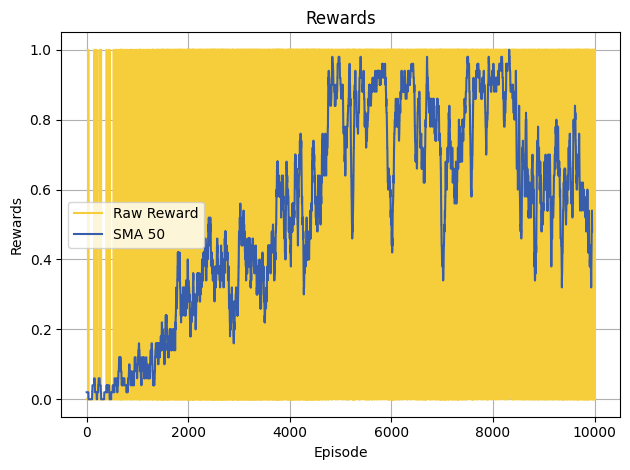

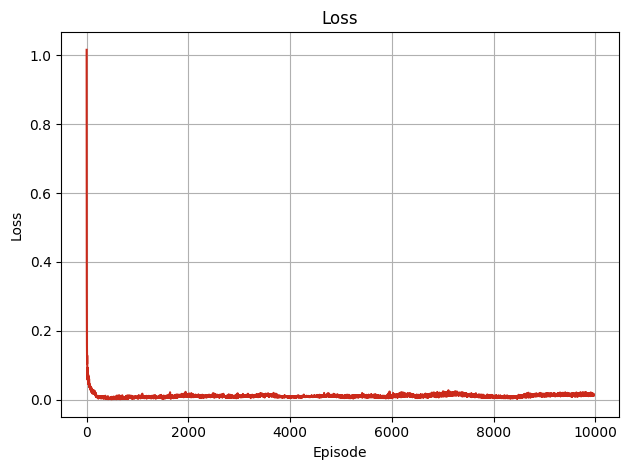

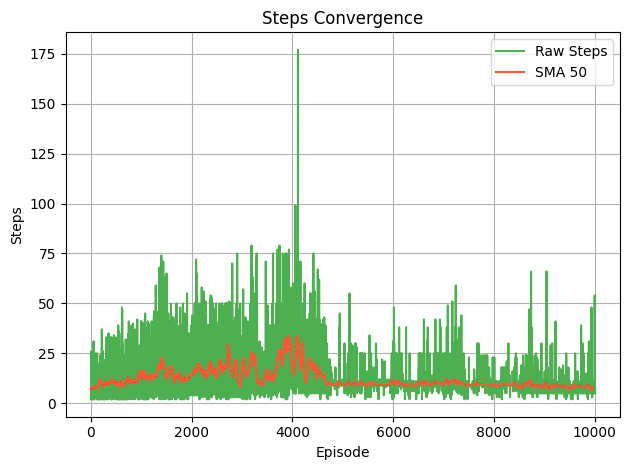

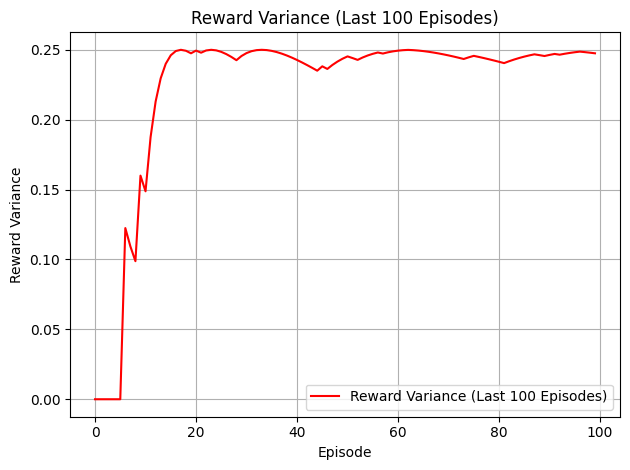

Training with hyperparams: {'epsilon_max': 0.79}
Episode: 100, Total Steps: 730, Ep Step: 12, Raw Reward: 0.00, Epsilon: 0.71
Episode: 200, Total Steps: 1612, Ep Step: 2, Raw Reward: 0.00, Epsilon: 0.65
Episode: 300, Total Steps: 2641, Ep Step: 6, Raw Reward: 0.00, Epsilon: 0.59
Episode: 400, Total Steps: 3752, Ep Step: 2, Raw Reward: 0.00, Epsilon: 0.53

~~~~~~Interval Save: Model saved.

Episode: 500, Total Steps: 4955, Ep Step: 11, Raw Reward: 0.00, Epsilon: 0.48
Episode: 600, Total Steps: 5931, Ep Step: 9, Raw Reward: 0.00, Epsilon: 0.43
Episode: 700, Total Steps: 6899, Ep Step: 2, Raw Reward: 0.00, Epsilon: 0.39
Episode: 800, Total Steps: 7879, Ep Step: 9, Raw Reward: 0.00, Epsilon: 0.35
Episode: 900, Total Steps: 9073, Ep Step: 10, Raw Reward: 1.00, Epsilon: 0.32

~~~~~~Interval Save: Model saved.

Episode: 1000, Total Steps: 10300, Ep Step: 12, Raw Reward: 0.00, Epsilon: 0.29
Episode: 1100, Total Steps: 11751, Ep Step: 6, Raw Reward: 0.00, Epsilon: 0.26
Episode: 1200, Total Step

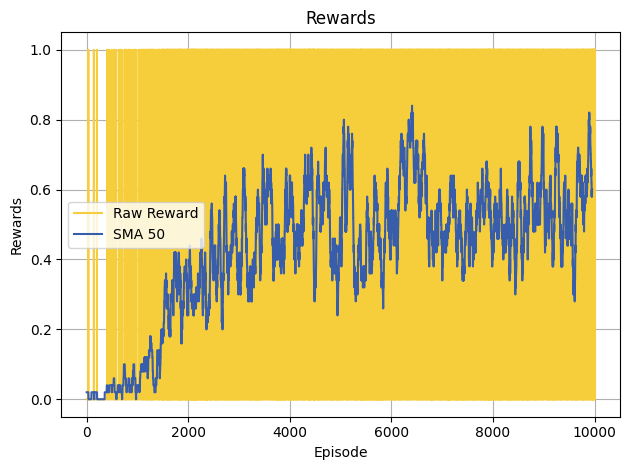

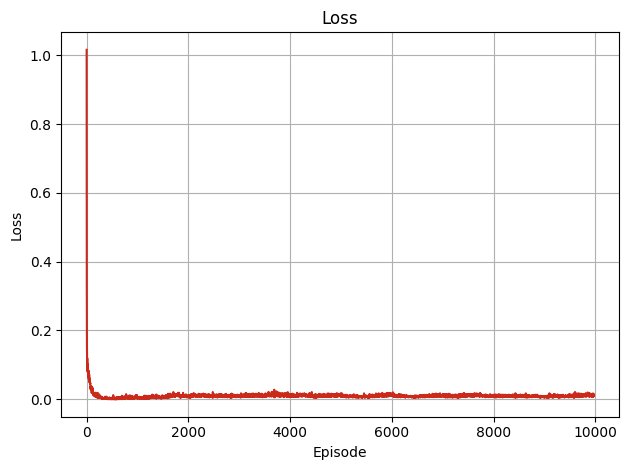

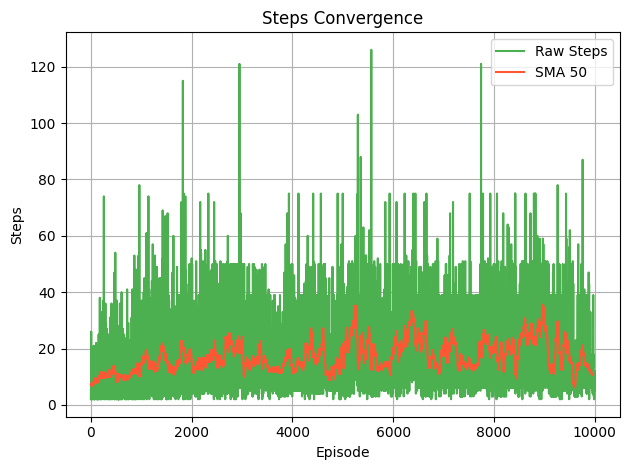

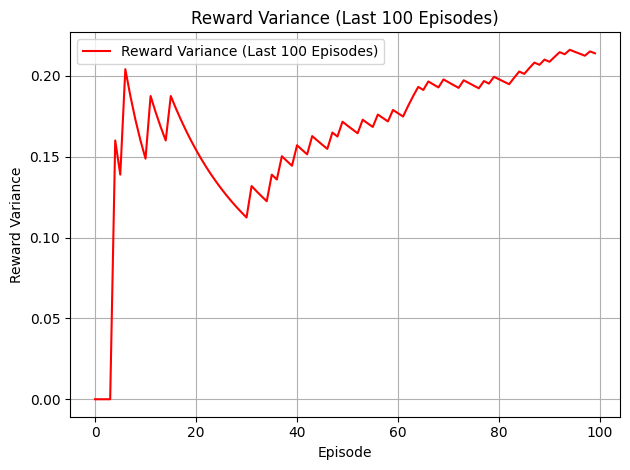

Training with hyperparams: {'epsilon_max': 0.8}
Episode: 100, Total Steps: 776, Ep Step: 6, Raw Reward: 0.00, Epsilon: 0.72
Episode: 200, Total Steps: 1567, Ep Step: 2, Raw Reward: 0.00, Epsilon: 0.65
Episode: 300, Total Steps: 2601, Ep Step: 12, Raw Reward: 0.00, Epsilon: 0.59
Episode: 400, Total Steps: 3685, Ep Step: 16, Raw Reward: 0.00, Epsilon: 0.54

~~~~~~Interval Save: Model saved.

Episode: 500, Total Steps: 4721, Ep Step: 6, Raw Reward: 0.00, Epsilon: 0.49
Episode: 600, Total Steps: 5756, Ep Step: 8, Raw Reward: 0.00, Epsilon: 0.44
Episode: 700, Total Steps: 6969, Ep Step: 3, Raw Reward: 0.00, Epsilon: 0.40
Episode: 800, Total Steps: 8118, Ep Step: 12, Raw Reward: 0.00, Epsilon: 0.36
Episode: 900, Total Steps: 9420, Ep Step: 6, Raw Reward: 0.00, Epsilon: 0.33

~~~~~~Interval Save: Model saved.

Episode: 1000, Total Steps: 10558, Ep Step: 8, Raw Reward: 0.00, Epsilon: 0.29
Episode: 1100, Total Steps: 11749, Ep Step: 9, Raw Reward: 0.00, Epsilon: 0.27
Episode: 1200, Total Steps:

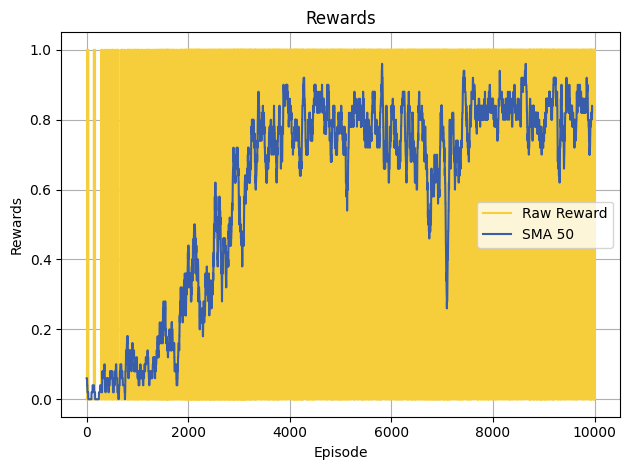

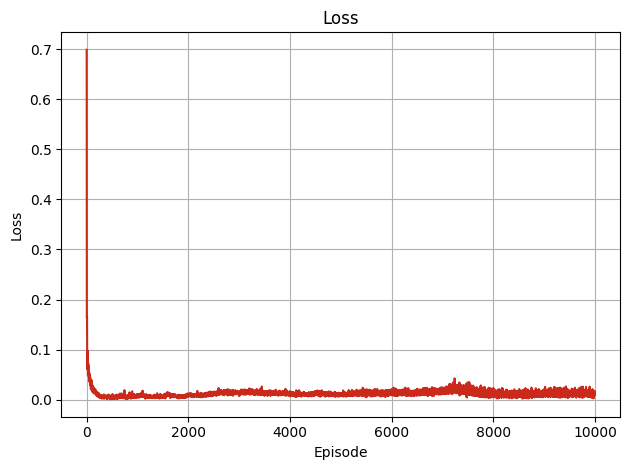

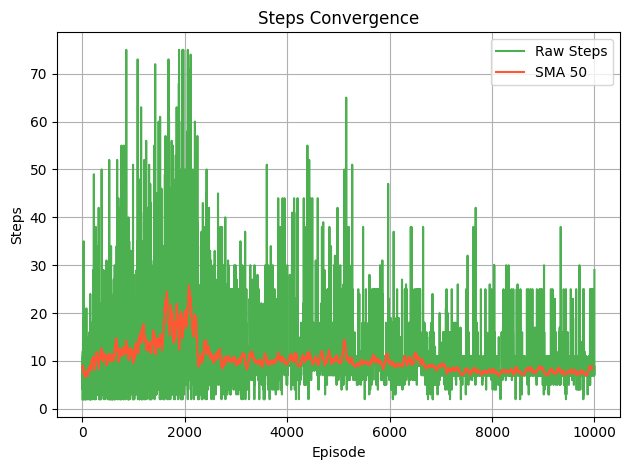

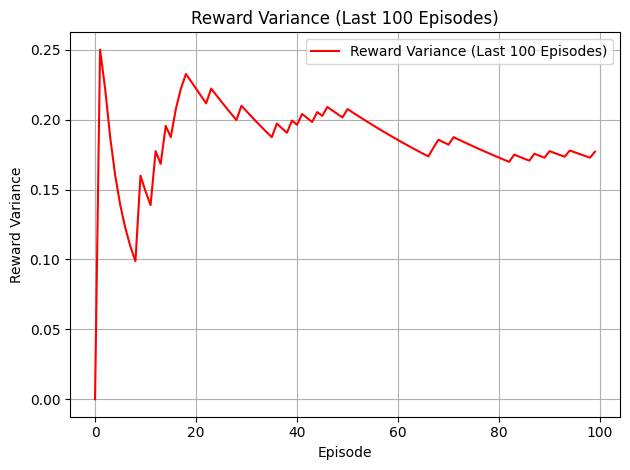

Training with hyperparams: {'epsilon_max': 0.81}
Episode: 100, Total Steps: 860, Ep Step: 5, Raw Reward: 0.00, Epsilon: 0.73
Episode: 200, Total Steps: 1825, Ep Step: 5, Raw Reward: 0.00, Epsilon: 0.66
Episode: 300, Total Steps: 2872, Ep Step: 5, Raw Reward: 0.00, Epsilon: 0.60
Episode: 400, Total Steps: 3898, Ep Step: 11, Raw Reward: 0.00, Epsilon: 0.54

~~~~~~Interval Save: Model saved.

Episode: 500, Total Steps: 5130, Ep Step: 4, Raw Reward: 0.00, Epsilon: 0.49
Episode: 600, Total Steps: 6215, Ep Step: 11, Raw Reward: 0.00, Epsilon: 0.44
Episode: 700, Total Steps: 7250, Ep Step: 11, Raw Reward: 0.00, Epsilon: 0.40
Episode: 800, Total Steps: 8102, Ep Step: 10, Raw Reward: 0.00, Epsilon: 0.36
Episode: 900, Total Steps: 9238, Ep Step: 5, Raw Reward: 0.00, Epsilon: 0.33

~~~~~~Interval Save: Model saved.

Episode: 1000, Total Steps: 10509, Ep Step: 9, Raw Reward: 0.00, Epsilon: 0.30
Episode: 1100, Total Steps: 11550, Ep Step: 14, Raw Reward: 0.00, Epsilon: 0.27
Episode: 1200, Total Ste

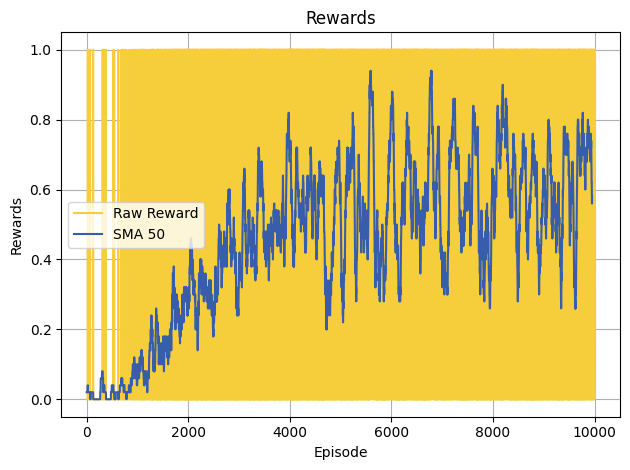

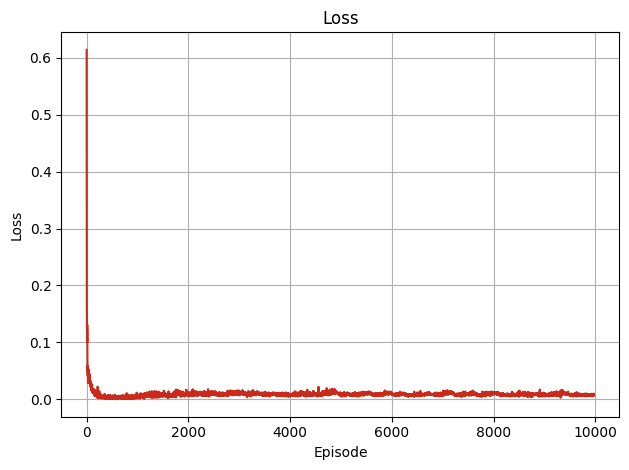

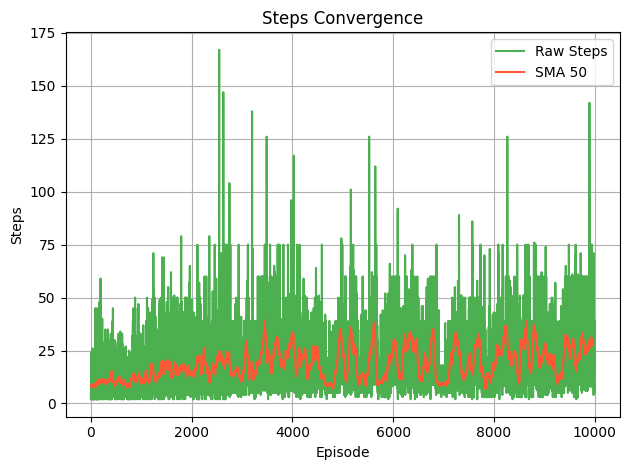

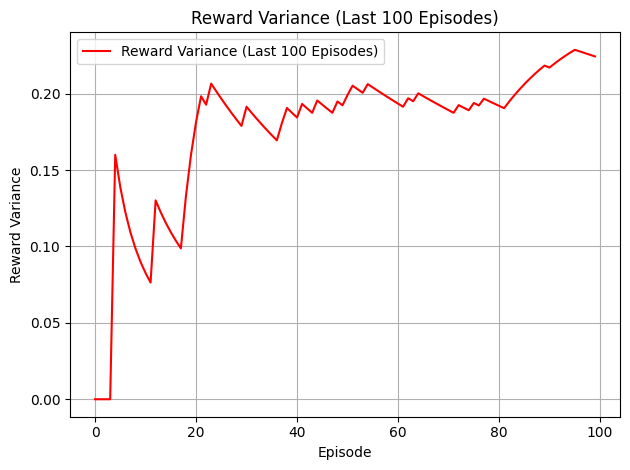

Best hyperparams: {'epsilon_max': 0.8} with average reward: 0.77 and reward variance: 0.18


In [3]:
import numpy as np
import itertools

# Parameter names and search spaces
param_names = ["epsilon_max"]
param_values = [np.arange(0.78, 0.82, 0.01)]  # Parameters a、b、c: Search from a to b，with an increase c each time
param_combinations = list(itertools.product(*param_values))

results = []

for params in param_combinations:
    # Unpack parameters
    hyperparams = dict(zip(param_names, params))
    print(f"Training with hyperparams: {hyperparams}")

    # Update configuration
    config.update(hyperparams)

     # Set seed
    seed_everything(seed)

    # Create environment
    env = gym.make(
        'FrozenLake-v1', 
        map_name=f"{config['map_size']}x{config['map_size']}", 
        is_slippery=True, 
        max_episode_steps=config['max_steps'], 
        render_mode="human" if config['render'] else None)

    env.reset(seed=seed)
    env.action_space.seed(seed)
    env.metadata['render_fps'] = config['render_fps']

    agent = DQNAgent(env, config)
    trainer = Trainer(env, agent, config)

    trainer.train()

    # Calculate the average reward for the last 100 episodes
    avg_reward = np.mean(trainer.reward_history[-100:])

    # Calculate the variance of the reward in last 100 episodes
    reward_variance = np.var(trainer.reward_history[-100:]) 

    # Record result
    results.append((hyperparams, avg_reward, reward_variance))
    results.append((hyperparams, avg_reward))

# Print the best combination of hyperparameters and the corresponding mean reward and reward variance
best_params = max(results, key=lambda x: x[1])
best_avg_reward, best_variance = best_params[1], best_params[2]
print(f"Best hyperparams: {best_params[0]} with average reward: {best_avg_reward:.2f} and reward variance: {best_variance:.2f}")